# Lecture 12 - Introduction to Approximate Solutions to PDEs

In the formulation of microscopic balance expressions to solve heat and mass transport problems, approximations that simplify the expressions are often used. These approximations fall into three categories.

- **Approximations Based on Length Scale**
    
    - Symmetry
    
    - Thinness
    
    - Series Resistance
    
    - Integral Transformations

- **Approximations Based on Time Scale**

    - Pseudo-steady state approximation
   
    - Penetration at "Early Times"
    
- **Numerical Solutions**
    
    - Numerical Solutions of ODE's 
    
    - Finite Volume Methods
    
    - Finite Difference
    
    - Finite Element Analysis 
   
In subsequent lectures, we will cover approximations based both on length and time scale, but for this lecture I want to focus on **numerical solutions** and more specifically the Finite difference method. 


## Finite Difference Method

In the finite difference method, we formulate an approximate solution to a PDE and B.C.'s by descritizing the domain into rectangular segments. Each segment within the domain is required to satisfy the approximate form of the microscopic balance expression. The partial derivatives that appear in the microscopic balance expression are approximated. 

$$\dfrac{d^2 \theta}{d x^2}\approx \dfrac{\theta_{i-1}-2\theta_{i}+\theta_{i+1}}{\Delta x^2}$$

$$\dfrac{d \theta}{d x}\approx \dfrac{\theta_{i+1}-\theta_{i-1}}{2\Delta x}$$

These approximations allow us to transform our PDE into a system of linear or non-linear algebraic equations that can be solved numerically. To solve PDE's numerically, there are a variety of methods, but a powerful capability built in Python is the [SciKit FiniteDiff](https://scikit-fdiff.readthedocs.io/en/latest/index.html) package. 

This package is easy to use and illustrates the flexibility of the finite difference method to solve PDE's in 1, 2, or 3-dimensions for both their transient and steady state behavior.



## Approximate Solutions to PDEs

## Illustrating the use of the Finite Difference Method and skdiff

Suppose you have a transient conduction problem given by the following PDE:

$$\dfrac{\partial \theta}{\partial \tau}=\dfrac{\partial^2 \theta}{\partial x^2}+\dfrac{\partial^2 \theta}{\partial y^2}$$

subject to the boundary conditions:

$\quad (1)\quad \theta(x=0,y)=1$

$\quad (2)\quad \theta(x=1,y)=0$

$\quad (3)\quad \theta(x,y=0)=1$

$\quad (4)\quad \theta(x,y=1)=0$

The starting point is to solve the transient diffusion problem specied by the microscopic balance and boundary conditions given above. 


### 1. Load the necessary packages

In [3]:
# We use numpy (for array related operations) and matplotlib (for plotting) 
# because they will help us a lot
import numpy as np
import matplotlib.pyplot as plt
from skfdiff import Model, Simulation

Zarr module not found, ZarrContainer not available.


### 2. Define some properties of our 2-D domain and the mesh

For the purposes of this demo, we will assume that the spacing $\Delta x$ is uniform along both the $x$ and $y$ directions

In [13]:
N = 51
dx = 1/N
AR = 1

### 3. Define Uniform mesh

The mesh is a 2-D array whose $M$ rows and $N$ columns represent the physical domain over which we seek a solution. We can construct this mesh using [np.arange](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) and [np.meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) functions. If $x$ and $y$ are $M$ and $N$ dimensional arrays defined by the desired shape of an $M\times N$ array, then meshgrid return two $M\times N$ dimensional arrays whose entries contain the $x$ and $y$ positions within that domain at each mesh point.

The dependent variable, $T$, should inheret the shape of the mesh and for now we set every entry within $T$ to zero using the np.zeros function.

In [14]:
x=np.arange(0,1+dx,dx)##this will be the rows of the array
y=np.arange(0,1*AR+dx,dx)##this will be the columns of the array
xx,yy=np.meshgrid(x,y,indexing="ij")
T=np.zeros(np.shape(xx))

### 4. Define the PDE and the Boundary Conditions

The functions below specify the governing differential equation defined by our Model and the boundary conditions. skfdiff uses [sympy](https://www.sympy.org/en/index.html) to define the boundary conditions and microscopic balance. An example in sympy is given below demonstrating the power of sympy. It is allows for expression evaluation on abstract mathematical objects including functions.

Two examples are given below, but many more are illustrated [here](https://docs.sympy.org/latest/tutorials/intro-tutorial/intro.html#a-more-interesting-example)

In [15]:
from sympy import symbols, limit, solve
from math import sin

## Example 1 - manipulating expressions and algebra
a, b = symbols('a b')
expr = a+2*b
print(expr-10*b)

## Example 2 - evaluating limits
z = symbols('z')
print(solve(z**2-2, z))


a - 8*b
[-sqrt(2), sqrt(2)]


For clarity and learning purposes, I have written the general form of the transient diffusion expression as:

$$\dfrac{\partial \theta}{\partial \tau}=
k\bigg(\dfrac{\partial^2 \theta}{\partial x^2}+\dfrac{\partial^2 \theta}{\partial y^2}\bigg)+b$$

where parameters $k$ and $b$ define the physics of the model. To model our transient diffusion problem above, we set $b=0$ and $k=1$. The boundary conditions are linear and of the Dirichlet form. Both Neumann, no flux, periodic, and Robin conditions are supported as part of the model specification.


In [16]:
##Specify the boundary conditions
bc = {("T", "x"): ("dirichlet", "dirichlet"),
      ("T", "y"): ("dirichlet", "dirichlet")}

b=0
k=1
      
model = Model("k * (dxxT + dyyT)+b",
              "T(x, y)", parameters=("k","b"), 
              boundary_conditions = bc)

### 5. Set the Initial Condition of the domain

As the solver evolves the solution from an initial condition, this must be supplied. We have set the value of the $T=0$ everywhere within the domain, but before we solve, we must handle the boundary conditions. We can do this using array slicing. As shown below

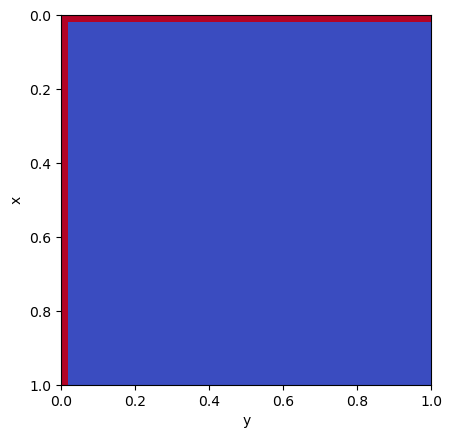

In [17]:
##set boundary conditions
T[0,:]=1##This is the first row, all columns
T[:,0]=1##This is the first colum, all rows

##We plot it to confirm that our boundary conditions are correct
plt.imshow(T,cmap="coolwarm",extent=[0,AR,1,0])
plt.ylabel(r'x')
plt.xlabel(r'y')

##Fields defines the dependent and independent variables and any parameters of the model
initial_fields = model.Fields(x=x, y=y, T=T, k=k, b=b)

### 6. Iterate in time to find solution at given time step 

In [18]:
simulation = Simulation(model, initial_fields, dt=0.05, tmax=10)
tmax, last_fields = simulation.run()

581cfa running: t: 10: : 200it [00:13, 15.06it/s]                           


### 7. Display the Result

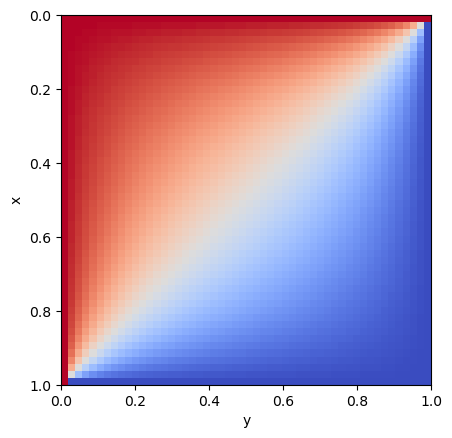

In [19]:
T=np.asarray(last_fields["T"])
plt.imshow(T,extent=(0,AR,1,0),cmap="coolwarm")
plt.ylabel(r'x')
plt.xlabel(r'y')
plt.show()

### 8. Slice the Result


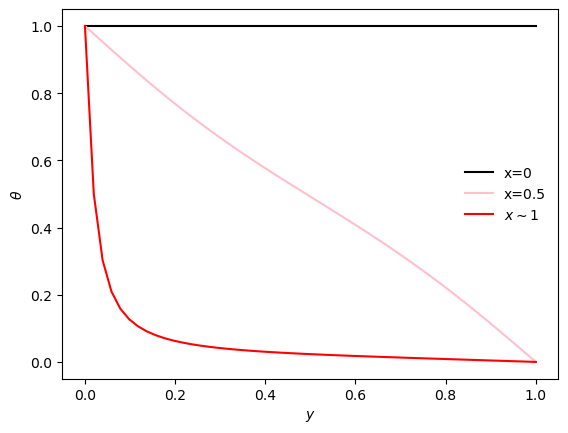

In [23]:
plt.plot(y,T[0,:],c='k',label='x=0')
plt.plot(y,T[round(N/2),:],c='pink',label='x=0.5')
plt.plot(y,T[-2,:],c='red',label='$x\sim1$')
plt.legend(frameon=False)
plt.ylabel(r'$\theta$')
plt.xlabel(r'$y$')
plt.show()

## Further Examples 
### Ex 1. Transient Diffusion Example with Finite Difference - Robin Boundary Conditions 
Suppose you have a fin where convection is dominant on the bounding surfaces and there is a constant temperature at the wall.

$$\dfrac{\partial \theta }{\partial \tau}=\dfrac{\partial^2 \theta}{\partial x^2}+\dfrac{\partial^2 \theta}{\partial y^2}$$

subject to the boundary conditions:

$\quad (1) \quad \theta(x,y=0)=1$

$\quad (2) \quad \dfrac{\partial\theta}{\partial x}\bigg|_{x,y=\gamma}=-Bi\theta$

$\quad (3) \quad \dfrac{\partial\theta}{\partial y}\bigg|_{x=0,y}=Bi\theta$

$\quad (4) \quad \dfrac{\partial\theta}{\partial y}\bigg|_{x=1,y}=-Bi\theta$

```{note}
In the above $x$ and $y$ are dimensionless lenght scales normalized to the fin's height $h$ and $\gamma$ is the aspect ratio of the fin given as the ratio of its height to its width and $\tau$ is the scaled time given as $\tau=\dfrac{t \alpha}{h^2}$.
```

### Finite Difference Formulation

Text(0.5, 0, 'y')

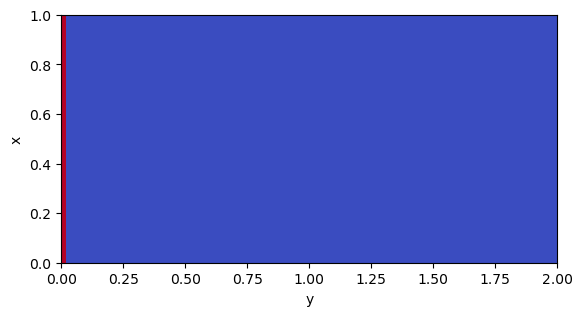

In [27]:
##set mesh properties
N = 51
dx = 1/N
AR = 2

##set x,y arrays and shape of T array
x=np.arange(0,1+dx,dx)
y=np.arange(0,1*AR+dx,dx)
xx,yy=np.meshgrid(x,y,indexing="ij")
T=np.zeros(np.shape(xx))

##define the boundary conditions and pass Biot number to it
Bi=10.0
left='dirichlet'
right="%g*T+dyT"%Bi
bottom="%g*T+dxT"%Bi
top="%g*T-dxT"%Bi

##format bc's into dictionary
bc = {("T", "x"): (top, bottom),
      ("T", "y"): (left, right)}


##add PDE and BC's to model
model = Model("(dxxT + dyyT)",
              "T(x, y)", 
              boundary_conditions = bc)


##set initial condition
T[:,0]=1##left boundary condition

initial_fields = model.Fields(x=x, y=y, T=T)
plt.imshow(T,cmap="coolwarm",extent=[0,AR,0,1])
plt.ylabel(r'x')
plt.xlabel(r'y')

### Solution

In [28]:
simulation = Simulation(model, initial_fields, dt=0.05, tmax=10)
tmax, last_fields = simulation.run()

5d96fe running: t: 10: : 200it [00:14, 13.68it/s]                           


### Post - Processing

Text(0.5, 0, 'y')

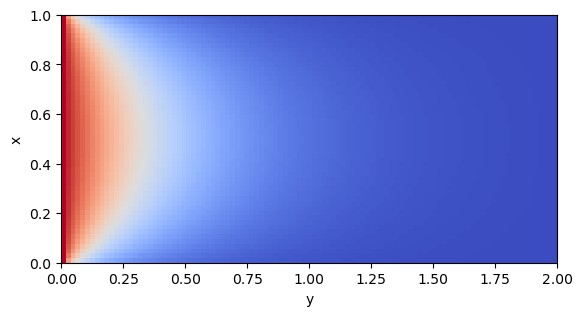

In [29]:
T=np.asarray(last_fields["T"])
plt.imshow(T,extent=(0,AR,0,1),cmap="coolwarm")
plt.ylabel(r'x')
plt.xlabel(r'y')

### Ex 2.  Increasing computational efficiency with symmetry in simulation
### Exploiting symmetry to simplify computation

Simplifications based on symmetry result in *reduction of dimensionality based on coordinate system choice*. We have now seen this by way of example 2 times.

1. Lecture 4 - we converted a two dimensional problem into a 1-D problem by selecting a cylindrical coordinate system

2. Lecture 5 - we converted a two dimensional problem into a 1-D problem by selecting a spherical coordinate system.

It is both the selection of coordinate system and the location of the origin of this coordinate system at axis of symmetry that make this reduction in complexity possible.

```{note}
Exploiting symmetry is one of the most effective tools to simplify numerical and analytical computations!
```

In the simulation above, we can see that the solution is symmetric about the center of the fin. This symmetry can be included to increase computational efficiency as follows:

$$\dfrac{\partial \theta }{\partial \tau}=\dfrac{\partial^2 \theta}{\partial x^2}+\dfrac{\partial^2 \theta}{\partial y^2}$$

subject to the boundary conditions:

$\quad (1) \quad \theta(x,y=0)=1$

$\quad (2) \quad \dfrac{\partial\theta}{\partial y}\bigg|_{\gamma,y=\gamma}=-Bi\theta$

$\quad (3) \quad \dfrac{\partial\theta}{\partial x}\bigg|_{x=0,y}=0$

$\quad (4) \quad \dfrac{\partial\theta}{\partial x}\bigg|_{x=0.5,y}=-Bi\theta$

We redefine the origin so that it is at the center of the fin, and then use a symmetry boundary condition in B.C. #3 to reduce the number of mesh points in half.

### Setting up the Simulation

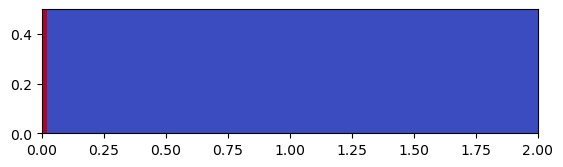

In [84]:
##set mesh properties
N = 51
dx = 1/N
AR = 2

##set x,y arrays and shape of T array
x=np.arange(0,0.5+dx,dx)
y=np.arange(0,1*AR+dx,dx)
xx,yy=np.meshgrid(x,y,indexing="ij")
T=np.zeros(np.shape(xx))

##define the boundary conditions and pass Biot number to it
Bi=0.05
left='dirichlet'
right="%g*T+dyT"%Bi
bottom="noflux"
top="%g*T-dxT"%Bi

##format bc's into dictionary
bc = {("T", "x"): (top, bottom),
      ("T", "y"): (left, right)}


##add PDE and BC's to model
model = Model("(dxxT + dyyT)",
              "T(x, y)", 
              boundary_conditions = bc)


##set initial condition
T[:,0]=1##left boundary condition

initial_fields = model.Fields(x=x, y=y, T=T)
plt.imshow(T,extent=(0,AR,0,0.5),cmap="coolwarm")

### Running the simulation 

In [85]:
simulation = Simulation(model, initial_fields, dt=0.05, tmax=10.0)
tmax, last_fields = simulation.run()

5be893 running: t: 10: : 200it [00:07, 25.91it/s]                           


### Post-Processing the simulated result

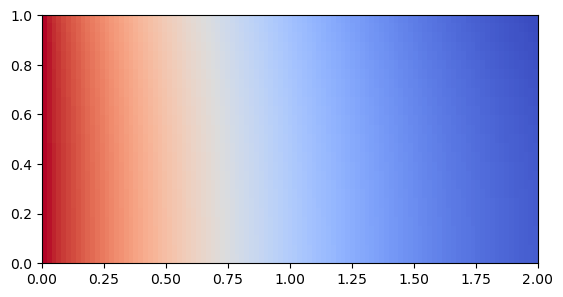

In [87]:
T=np.asarray(last_fields["T"])
plt.imshow(T,extent=(0,AR,0,1),cmap="coolwarm")

### Slicing the Domain for Post-Processing

By slicing the domain, we can now explictly observe the impact of symmetry



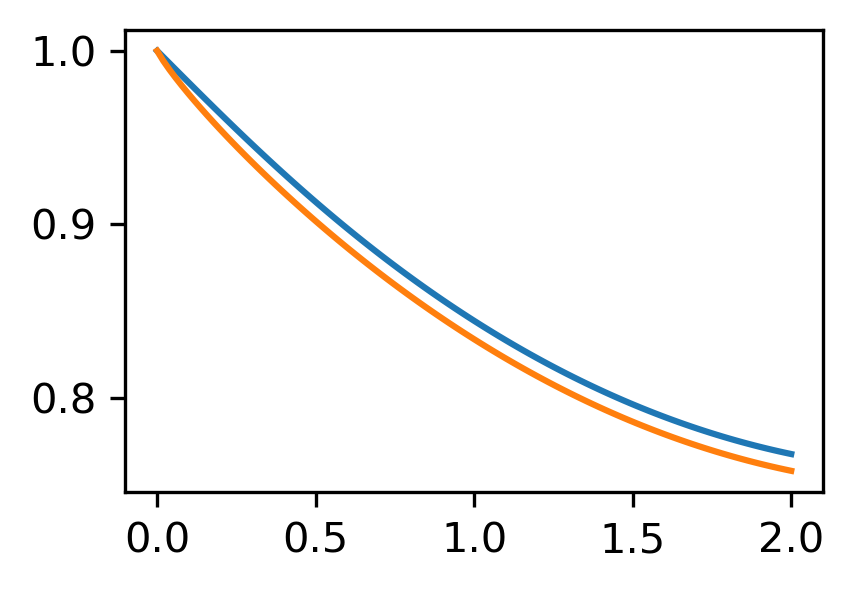

In [88]:
plt.figure(dpi=300,figsize=(3,2))
plt.plot(y,T[-1,:])
plt.plot(y,T[0,:])

## Ex. 3 Approximations Based on Thinness

The analytical and numerical effort required to solve problems in two or three dimensions often justifies the reduction of a more complicated problem where a dependent variable $\theta$ depends on more than one independent variable to one that requires only a single independent variable to solve. The mathematical reasons for this are clear: **partial differential equations** are generally more difficult to solve than **ordinary differential equations**, but even the numerical solutions can be significantly simplified



### Thinness

If one dimension of an object is much thinner than another, then in the region of space where the dimension is large the gradients along that direction will be much smaller than gradients present along the small dimension. As a consequence, the macroscopic quantities such as heat loss will be dominated by the region of space with large gradients and the small gradients will be considered incidental or unimportant. We call these regions of space **edge effects** as they happen at the edge of a geometry where the gradients along the long dimension change the most.

```{Note!}
The impact of edge effects can also be sought after the analytical solution in one dimension is obtained
```

#### Thinness is best demonstrated using finite difference method:

Consider a small modification to our original example:

$$\dfrac{\partial \theta}{\partial \tau}=\dfrac{\partial^2 \theta}{\partial x^2}+\dfrac{\partial^2 \theta}{\partial y^2}+1$$

subject to the boundary conditions:

$\quad (1) \quad \theta(x=0,y)=1$

$\quad (2) \quad \theta(x=1,y)=0$

$\quad (3)\quad \theta(x,y=0)=0$

$\quad (4)\quad \theta(x,y=1)=0$


30807d running: t: 0.1: 100%|██████████| 10/10.0 [00:00<00:00, 13.63it/s] 


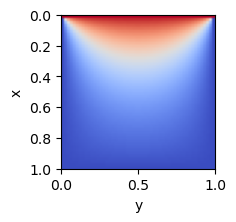

d2e3be running: t: 0.1: 100%|██████████| 10/10.0 [00:00<00:00, 11.82it/s]


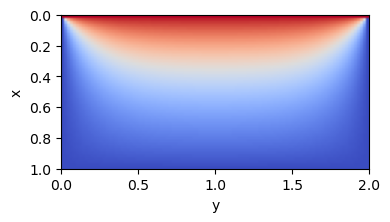

710c1f running: t: 0.1: 100%|██████████| 10/10.0 [00:00<00:00, 10.38it/s]


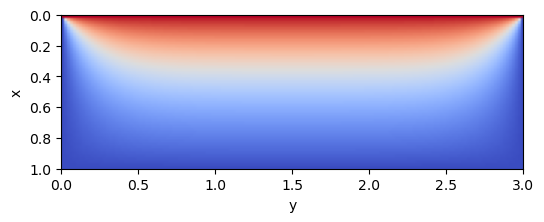

e51dd2 running: t: 0.1: 100%|██████████| 10/10.0 [00:01<00:00,  5.50it/s] 


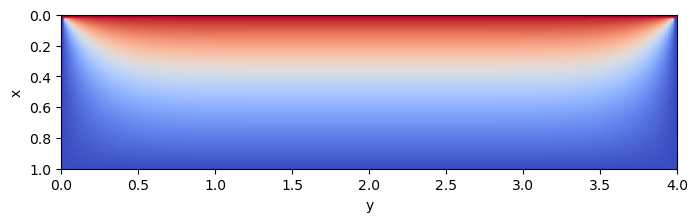

176493 running: t: 0.1: 100%|██████████| 10/10.0 [00:01<00:00,  5.69it/s]


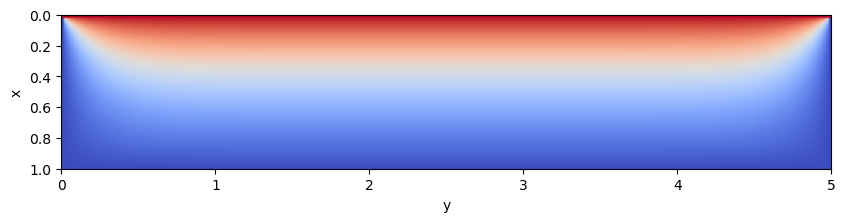

In [90]:
##set mesh properties
def compute_(AR=1):
    N = 51
    dx = 1/N

    ##set x,y arrays and shape of T array
    x=np.arange(0,1+dx,dx)
    y=np.arange(0,1*AR+dx,dx)
    xx,yy=np.meshgrid(x,y,indexing="ij")
    T=np.zeros(np.shape(xx))

    ##define the boundary conditions and pass Biot number to it
    left="dirichlet"
    right="dirichlet"
    bottom="dirichlet"
    top="dirichlet"

    ##format bc's into dictionary
    bc = {("T", "x"): (top, bottom),
          ("T", "y"): (left, right)}


    ##add PDE and BC's to model
    model = Model("(dxxT + dyyT)+1",
                  "T(x, y)", 
                  boundary_conditions = bc)


    ##set initial condition
    ##set boundary conditions
    T[0,:]=1


    initial_fields = model.Fields(x=x, y=y, T=T)
    #plt.imshow(T,extent=(0,AR,0,1));
    #plt.title(r'')
    simulation = Simulation(model, initial_fields, dt=0.01, tmax=0.1)
    tmax, last_fields = simulation.run()
    T=np.asarray(last_fields["T"])
    
    plt.figure(dpi=100,figsize=(2*AR,2))
    plt.imshow(T,extent=(0,AR,1,0),cmap="coolwarm")
    plt.ylabel(r'x')
    plt.xlabel(r'y')
    plt.show()
    
    return T
    ##compute the flux
AR_=[]
T_=[]
for AR in [1,2,3,4,5]:
    T_.append(compute_(AR))
    AR_.append(AR)
    
    